In [ ]:
# default_exp avi

# AVI Module

> This module is a class that makes it easier to interface with the Dataset modules. The module can be used to load a single frame from a particular video in the dataset.

Finally 
Note: The original dataset is relatively small (9.5GB). However, it can be extremely slow to load and decode video files from memory. Because of this, sometime (e.g. here) video files are stored as numpy arrays of size [sequence_length,height,width,3]. This makes them very quick to load but extremely large (~500GB). In this case, the dataset is stored as hdf5 files. This function can also convert the avi paths to hdf5.

In [ ]:
#hide
from nbdev.showdoc import *

In [1]:
#export
import numpy as np
import cv2
import pathlib
import matplotlib.pyplot as plt
from PIL import Image

import torch

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
class AVI:
    def __init__(self, filename, toPIL=False, verbose=False):
        self._filename = pathlib.Path(filename)
        self.toPIL = toPIL
        self.verbose = verbose
        cap = cv2.VideoCapture(self._filename.as_posix())   
        self._attributes = {}
        self._attributes['n-frames']     = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self._attributes['frame-width']  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._attributes['frame-height'] = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self._attributes['fps']         = cap.get(cv2.CAP_PROP_FPS)
        cap.release()        
 
    def getFrame(self, frame_index):
        """Loads a single frame from a file at index frame_index.
        
        The data is returned and is a numpy array of size [n_channels, width, height] of type np.float32.
        """
        ### load file from AVI
        cap = cv2.VideoCapture(self._filename.as_posix())   
 
        if not cap.isOpened(): 
            print(f"could not open {self._filename.as_posix()}") 
            frame = np.array([])
            return frame

        self._attributes['frame-index']  = frame_index;        
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
        ret, frame = cap.read()  
        if frame is None:
            if self.verbose: print(f'ERROR in file: {self._filename.as_posix()}, frame-index: {frame_index}.')
            return frame

        cap.release()            
        
                    
        if self.toPIL: # .transpose(2,0,1)
            cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(cv2_im)            
        else:
            #frame = frame.astype(np.float32)
            frame = frame.astype(np.uint8)
            
        return frame
    
    def getRandomFrame(self, max_attempts=100):
        frame = None
        count = 0
        frame_index = None
        while frame is None and count < max_attempts:
            count += 1
            if frame_index is None:
                frame_index = np.random.randint(self._attributes['n-frames'])
                frame = self.getFrame(frame_index) 
                if frame is None:
                    if self.verbose: print(f'ERROR in file: {self._filename}, frame_index: {frame_index}. Retrying with different random frame number.')
                    frame_index = None
        return frame
    
    def getFrames(self, c, w, h, reshape=False, to_net_shape=False, normalise=False):
        # c, w, h = channels, width, heigth
        data = np.zeros((self._attributes['n-frames'], c, w, h), dtype=np.float32)

        for j in range(self._attributes['n-frames']):       
            frame = avi.getFrame(j)
            if reshape: frame = self.reshape(frame, (w, h))
            if normalise:  frame = self.normalise(frame)
            if to_net_shape: frame = AVI.toNetShape(frame)                
            data[j,:,:,:] = frame
#             AVI.frameShow(AVI.toImgShape(frame), avi._filename)
        return data
    
    @staticmethod
    def toNetShape(frame):
        # this function simply checks if the frame
        # is in the format Channels x Width x Height.
        if frame.shape[0] > 3:
#            frame.transpose(0, 1, 2)
            frame = frame.transpose(2, 0, 1)
        return frame
 
    @staticmethod
    def toImgShape(frame):
        if frame.shape[2] > 3:
            frame = frame.transpose(1, 2, 0)
        return frame
    
    @staticmethod
    def toImg(frame, normalise=True):
        # Checks if a tensor
        if type(frame) == torch.Tensor:
            frame = frame.data.numpy()
            # tensor images are usually in the form of channels x width x height
            #frame = frame.transpose(1, 2, 0)
            AVI.toImgShape(frame)
        
        # Normalises it to be ready to plot it with imshow.
        if normalise:
            frame = (frame-np.min(frame))/np.max(frame-np.min(frame))    
        return frame
    
#     def frameShow(self, frame, title=None):
#         plt.imshow(AVI.toImg(frame))
#         if title is None:
#             title = self._filename
#         plt.title(title)
        
    @staticmethod
    def frameShow(frame, title=None):
        plt.imshow(AVI.toImg(frame))
        if title is not None:
            plt.title(title)
            
            
    def set_normalisation(self, mean, std):
        self._attributes['mean'] = mean
        self._attributes['std'] = std
        
    def normalise(self, frame):
        frame = frame/255.0
        frame = (frame - self._attributes['mean'])/self._attributes['std']
        return frame

    def reshape(self, frame, out_shape):
        # out_shape is a tuple: (IMAGE_SIZE,IMAGE_SIZE)
        frame = cv2.resize(frame, out_shape)
        return frame
        
    

Quickly test the AVI class:

In [4]:
avi = AVI('../data/UCF101/UCF-101/YoYo/v_YoYo_g25_c05.avi', toPIL=True)
print(avi._attributes)

{'n-frames': 196, 'frame-width': 320, 'frame-height': 240, 'fps': 25.0}


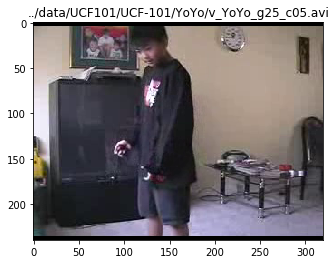

In [5]:
avi.frameShow(avi.getFrame(10), avi._filename)

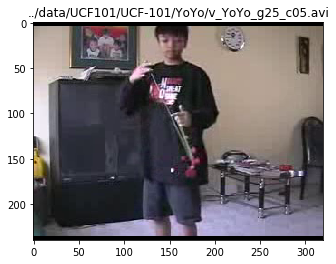

In [6]:
avi.frameShow(avi.getRandomFrame(max_attempts=1), avi._filename)

# fin

In [8]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_dataset_ucf101.ipynb.
Converted 02_avi.ipynb.
Converted 04_data_augmentation.ipynb.
Converted 05_models.ipynb.
Converted index.ipynb.
